In [1]:
import pandas as pd
import os
import glob
import numpy as np

# =============================================================================
# --- Configuration ---
# =============================================================================
# The folder containing your 24 TRAINING subject CSV files.
TRAINING_DATA_FOLDER = './csv_folder/' 

# The name for our final, master training dataset file.
OUTPUT_TRAINING_CSV = 'master_training_dataset_imputed.csv'

# The subject ID that has the missing channel.
SUBJECT_WITH_MISSING_DATA = 'EPCTL05'
# The channel that is missing.
MISSING_CHANNEL = 'F4'
# The neighboring channels we will use for imputation.
NEIGHBOR_CHANNELS = ['Fp2', 'C4', 'F8']

# =============================================================================
# --- Main Execution ---
# =============================================================================
print("--- Starting: Consolidating data with Smart Subject ID Correction ---")

# --- 1. Find and Load All Training CSV Files ---
search_path = os.path.join(TRAINING_DATA_FOLDER, '*.csv')
all_subject_files = glob.glob(search_path)

if not all_subject_files:
    print(f"ERROR: No CSV files found in {TRAINING_DATA_FOLDER}")
    exit()

print(f"Found {len(all_subject_files)} subject CSV files to merge.")
list_of_dataframes = []

# --- 2. Load Files and Assign Correct Subject IDs ---
print("Loading files and assigning correct Subject IDs from filenames...")
for f in all_subject_files:
    # Extract the base filename and then the subject ID
    base_name = os.path.basename(f)
    subject_id = base_name.split('_')[0]
    
    df = pd.read_csv(f)
    
    # Ignore the old subject_id column and create a new, correct one
    if 'subject_id' in df.columns:
        df = df.drop(columns=['subject_id'])
    df['subject_id'] = subject_id
    
    list_of_dataframes.append(df)
    print(f"  - Loaded data for subject: {subject_id}")


# --- 3. Merge DataFrames, Keeping All Columns ---
print("\nMerging all dataframes (this will create NaN values)...")
master_df = pd.concat(list_of_dataframes, ignore_index=True, join='outer')
print("Merge complete.")

# --- 4. Perform Spatial Imputation for the Missing Channel ---
print(f"\n--- Performing Spatial Imputation for Subject: {SUBJECT_WITH_MISSING_DATA} ---")

f4_columns = [col for col in master_df.columns if col.startswith(f'{MISSING_CHANNEL}_')]

if master_df[f4_columns].isnull().sum().sum() > 0:
    print(f"Found {len(f4_columns)} features for channel {MISSING_CHANNEL} that need imputation.")
    
    for f4_col in f4_columns:
        base_feature = '_'.join(f4_col.split('_')[1:])
        neighbor_cols = [f'{neighbor}_{base_feature}' for neighbor in NEIGHBOR_CHANNELS]
        
        if all(col in master_df.columns for col in neighbor_cols):
            imputed_values = master_df[neighbor_cols].mean(axis=1)
            master_df[f4_col].fillna(imputed_values, inplace=True)
            print(f"  - Imputed missing values for: {f4_col}")
        else:
            print(f"  - WARNING: Could not find all neighbor columns for {f4_col}. Skipping.")
            
    final_missing_count = master_df[f4_columns].isnull().sum().sum()
    if final_missing_count == 0:
        print("\n--- Imputation Successful ---")
    else:
        print(f"\n--- Imputation Incomplete ---")

else:
    print("No missing values found for F4 columns. No imputation was needed.")

# --- 5. Save the Master Dataset ---
print(f"\nSaving the imputed master training dataset to: {OUTPUT_TRAINING_CSV}")
master_df.to_csv(OUTPUT_TRAINING_CSV, index=False)
print("File saved successfully.")

print("\n--- Consolidation Complete ---")

--- Starting: Consolidating data with Smart Subject ID Correction ---
Found 24 subject CSV files to merge.
Loading files and assigning correct Subject IDs from filenames...
  - Loaded data for subject: EPCTL02
  - Loaded data for subject: EPCTL03
  - Loaded data for subject: EPCTL05
  - Loaded data for subject: EPCTL06
  - Loaded data for subject: EPCTL07
  - Loaded data for subject: EPCTL09
  - Loaded data for subject: EPCTL10
  - Loaded data for subject: EPCTL11
  - Loaded data for subject: EPCTL12
  - Loaded data for subject: EPCTL13
  - Loaded data for subject: EPCTL14
  - Loaded data for subject: EPCTL15
  - Loaded data for subject: EPCTL16
  - Loaded data for subject: EPCTL17
  - Loaded data for subject: EPCTL18
  - Loaded data for subject: EPCTL19
  - Loaded data for subject: EPCTL20
  - Loaded data for subject: EPCTL22
  - Loaded data for subject: EPCTL23
  - Loaded data for subject: EPCTL24
  - Loaded data for subject: EPCTL26
  - Loaded data for subject: EPCTL27
  - Loaded da

--- Starting Deep Exploratory Data Analysis for the Master Dataset ---
Successfully loaded the master dataset.
Shape of the data: 21683 rows (epochs), 102 columns (features)

--- [A] Data Integrity and Structure ---
Verifying data types and checking for missing values...
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21683 entries, 0 to 21682
Columns: 102 entries, sleep_stage to subject_id
dtypes: float64(99), int64(1), object(2)
memory usage: 16.9+ MB

SUCCESS: Your dataset has no missing values. Imputation was successful.

--- [B] Deep Analysis of Sleep Stage Distribution (Class Balance) ---
Distribution of sleep stages across all subjects:
             Count  Percentage
sleep_stage                   
N2            8226       37.94
Wake          5302       24.45
N3            3676       16.95
REM           2488       11.47
N1            1991        9.18


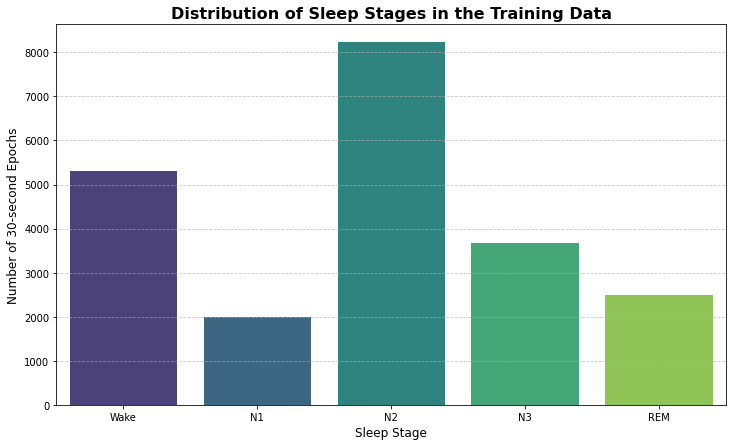


--- [C] Deep Analysis of Key Feature Effectiveness ---
Using Violin Plots to show the full distribution of feature values per stage.


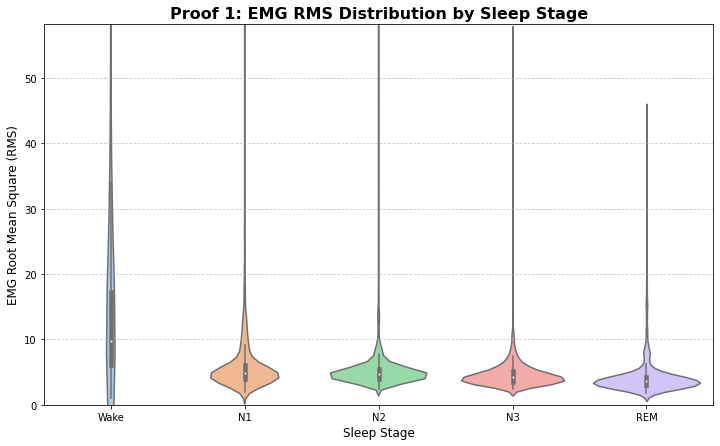

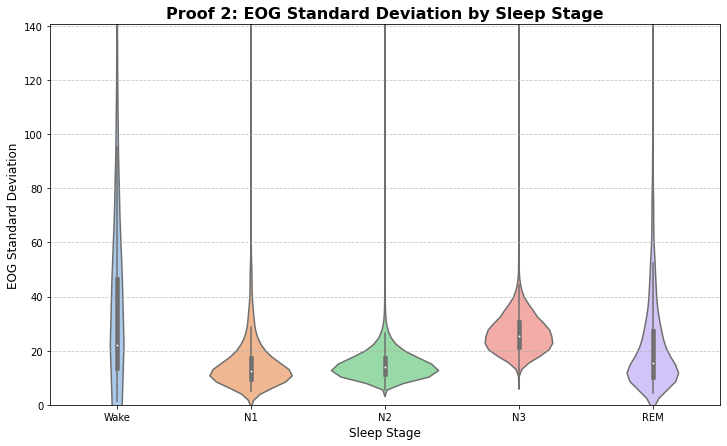


--- [D] Analyzing EEG Spectral Fingerprints ---


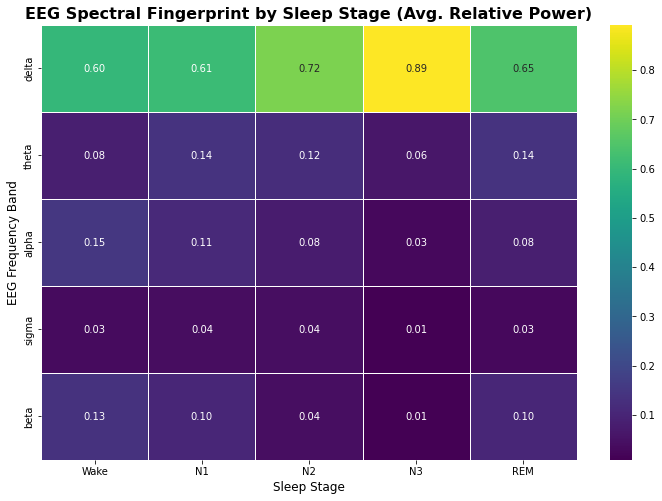


--- FINAL PREPROCESSING PLAN (BASED ON DEEP ANALYSIS) ---
1. SEPARATE FEATURES AND LABELS:
   - X = df.drop(columns=['subject_id', 'sleep_stage', 'is_rem'])
   - y = df['sleep_stage'] (or df['is_rem'] for binary classification)

2. LABEL ENCODING:
   - The 'sleep_stage' column is text ('Wake', 'N1', etc.). Models need numbers.
   - You must convert these text labels into numerical labels (e.g., Wake=0, N1=1, N2=2, N3=3, REM=4).

3. FEATURE SCALING (Standardization):
   - Your features have very different scales (e.g., power is 0-1, while std can be large).
   - It is best practice to scale all features to have a mean of 0 and a standard deviation of 1. Use scikit-learn's `StandardScaler` for this.

4. HANDLE CLASS IMBALANCE (CRITICAL):
   - Our analysis of the class distribution shows a significant imbalance (lots of N2, very little N1/N3).
   - STRONGLY RECOMMENDED: Use a technique like SMOTE (Synthetic Minority Over-sampling Technique) on your training data to create synthetic examp

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import os

# =============================================================================
# --- Configuration ---
# =============================================================================
# The master dataset file we created in the last step.
MASTER_CSV_PATH = 'master_training_dataset_imputed.csv'

# =============================================================================
# --- Main Analysis Script ---
# =============================================================================
print("--- Starting Deep Exploratory Data Analysis for the Master Dataset ---")

# --- 1. Load the Dataset ---
try:
    df = pd.read_csv(MASTER_CSV_PATH)
    print(f"Successfully loaded the master dataset.")
    print(f"Shape of the data: {df.shape[0]} rows (epochs), {df.shape[1]} columns (features)")
except FileNotFoundError:
    print(f"ERROR: The file was not found at: {MASTER_CSV_PATH}")
    print("Please make sure the file from the previous step exists.")
    exit()

# --- 2. Data Integrity and Structure ---
print("\n--- [A] Data Integrity and Structure ---")
print("Verifying data types and checking for missing values...")
# A concise summary of the dataframe, perfect for a quick overview.
df.info(verbose=False) 
missing_values = df.isnull().sum().sum()
if missing_values == 0:
    print("\nSUCCESS: Your dataset has no missing values. Imputation was successful.")
else:
    print(f"\nWARNING: Your dataset has {missing_values} missing values that need to be addressed.")

# --- 3. Deep Analysis of Sleep Stage Distribution ---
print("\n--- [B] Deep Analysis of Sleep Stage Distribution (Class Balance) ---")
stage_counts = df['sleep_stage'].value_counts()
stage_percentages = df['sleep_stage'].value_counts(normalize=True) * 100
stage_dist = pd.DataFrame({'Count': stage_counts, 'Percentage': stage_percentages.round(2)})
print("Distribution of sleep stages across all subjects:")
print(stage_dist)

plt.figure(figsize=(12, 7))
sns.countplot(x='sleep_stage', data=df, order=['Wake', 'N1', 'N2', 'N3', 'REM'], palette='viridis')
plt.title('Distribution of Sleep Stages in the Training Data', fontsize=16, weight='bold')
plt.xlabel('Sleep Stage', fontsize=12)
plt.ylabel('Number of 30-second Epochs', fontsize=12)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

# --- 4. Deep Analysis of Key Features ---
print("\n--- [C] Deep Analysis of Key Feature Effectiveness ---")
print("Using Violin Plots to show the full distribution of feature values per stage.")

# Proof 1: EMG RMS (Should be very low for REM)
plt.figure(figsize=(12, 7))
sns.violinplot(x='sleep_stage', y='emg_rms', data=df, order=['Wake', 'N1', 'N2', 'N3', 'REM'], palette='pastel')
plt.title('Proof 1: EMG RMS Distribution by Sleep Stage', fontsize=16, weight='bold')
plt.xlabel('Sleep Stage', fontsize=12)
plt.ylabel('EMG Root Mean Square (RMS)', fontsize=12)
# Zoom in on the main distribution by clipping the y-axis at the 99th percentile
plt.ylim(bottom=0, top=df['emg_rms'].quantile(0.99))
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

# Proof 2: EOG Standard Deviation (Should be high for REM and Wake)
plt.figure(figsize=(12, 7))
sns.violinplot(x='sleep_stage', y='eog_std', data=df, order=['Wake', 'N1', 'N2', 'N3', 'REM'], palette='pastel')
plt.title('Proof 2: EOG Standard Deviation by Sleep Stage', fontsize=16, weight='bold')
plt.xlabel('Sleep Stage', fontsize=12)
plt.ylabel('EOG Standard Deviation', fontsize=12)
plt.ylim(bottom=0, top=df['eog_std'].quantile(0.99)) # Zoom in
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

# Proof 3: EEG Spectral "Fingerprints" (The Brain State)
print("\n--- [D] Analyzing EEG Spectral Fingerprints ---")
# We will calculate the average power for each band in each stage
eeg_power_cols = [col for col in df.columns if 'rel_power' in col]
eeg_fingerprints = df.groupby('sleep_stage')[eeg_power_cols].mean()
# To make it easier to visualize, we'll average across all channels for the plot
bands = ['delta', 'theta', 'alpha', 'sigma', 'beta']
plot_data = pd.DataFrame()
for band in bands:
    band_cols = [col for col in eeg_fingerprints.columns if band in col]
    plot_data[band] = eeg_fingerprints[band_cols].mean(axis=1)

# Ensure the stages are in a logical order for the plot
plot_data = plot_data.reindex(['Wake', 'N1', 'N2', 'N3', 'REM'])
plt.figure(figsize=(12, 8))
sns.heatmap(plot_data.T, annot=True, fmt=".2f", cmap='viridis', linewidths=.5)
plt.title('EEG Spectral Fingerprint by Sleep Stage (Avg. Relative Power)', fontsize=16, weight='bold')
plt.xlabel('Sleep Stage', fontsize=12)
plt.ylabel('EEG Frequency Band', fontsize=12)
plt.show()

# --- 5. The Final Preprocessing Plan ---
print("\n" + "="*60)
print("--- FINAL PREPROCESSING PLAN (BASED ON DEEP ANALYSIS) ---")
print("="*60)
print("1. SEPARATE FEATURES AND LABELS:")
print("   - X = df.drop(columns=['subject_id', 'sleep_stage', 'is_rem'])")
print("   - y = df['sleep_stage'] (or df['is_rem'] for binary classification)")
print("\n2. LABEL ENCODING:")
print("   - The 'sleep_stage' column is text ('Wake', 'N1', etc.). Models need numbers.")
print("   - You must convert these text labels into numerical labels (e.g., Wake=0, N1=1, N2=2, N3=3, REM=4).")
print("\n3. FEATURE SCALING (Standardization):")
print("   - Your features have very different scales (e.g., power is 0-1, while std can be large).")
print("   - It is best practice to scale all features to have a mean of 0 and a standard deviation of 1. Use scikit-learn's `StandardScaler` for this.")
print("\n4. HANDLE CLASS IMBALANCE (CRITICAL):")
print("   - Our analysis of the class distribution shows a significant imbalance (lots of N2, very little N1/N3).")
print("   - STRONGLY RECOMMENDED: Use a technique like SMOTE (Synthetic Minority Over-sampling Technique) on your training data to create synthetic examples of the rare classes. This will help prevent the model from just ignoring them.")
print("   - Alternatively, use the `class_weight='balanced'` parameter in models like RandomForest or XGBoost.")

print("\n--- Deep Analysis Complete ---")
print("Your data is now fully understood, and you have a clear, evidence-based plan to prepare it for machine learning.")


In [1]:
import pandas as pd
import numpy as np
import os
import glob
import matplotlib.pyplot as plt
import seaborn as sns
import warnings

# --- Core ML Libraries ---
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, f1_score
from sklearn.model_selection import RandomizedSearchCV

# --- Model ---
import xgboost as xgb

# --- Imbalance Handling ---
from imblearn.over_sampling import ADASYN

# Suppress warnings for a cleaner output
warnings.filterwarnings('ignore')

# =============================================================================
# --- Configuration ---
# =============================================================================
# We start with the non-temporal dataset and create temporal features on the fly.
TRAINING_CSV_PATH = 'master_training_dataset_imputed.csv'
TEST_DATA_FOLDER = './test_subjects/'
TARGET_COLUMN = 'sleep_stage'

# =============================================================================
# --- Helper Functions ---
# =============================================================================
def create_temporal_features(df):
    """
    Creates temporal features (_prev, _next) for a given dataframe,
    grouped by subject to prevent data leakage.
    """
    feature_cols = [col for col in df.columns if col not in ['subject_id', 'sleep_stage', 'is_rem']]
    
    all_subjects_data = []
    for subject, subject_df in df.groupby('subject_id'):
        subject_df = subject_df.reset_index(drop=True)
        prev_epoch_features = subject_df[feature_cols].shift(1)
        prev_epoch_features.columns = [f'{col}_prev' for col in feature_cols]
        next_epoch_features = subject_df[feature_cols].shift(-1)
        next_epoch_features.columns = [f'{col}_next' for col in feature_cols]
        combined_df = pd.concat([subject_df, prev_epoch_features, next_epoch_features], axis=1)
        combined_df.fillna(method='bfill', inplace=True)
        combined_df.fillna(method='ffill', inplace=True)
        all_subjects_data.append(combined_df)
        
    return pd.concat(all_subjects_data, ignore_index=True)

# =============================================================================
# --- Main Execution ---
# =============================================================================
print("--- Starting State-of-the-Art Modeling Pipeline (Fast-Track) ---")

# --- 1. Load, Engineer, and Preprocess Training Data ---
print("\n--- [Phase 1] Preparing Training Data ---")
try:
    train_df_raw = pd.read_csv(TRAINING_CSV_PATH)
    print(f"Loaded raw training data: {train_df_raw.shape[0]} epochs")
except FileNotFoundError:
    print(f"ERROR: Training file not found at {TRAINING_CSV_PATH}")
    exit()

print("Creating temporal features for training set...")
train_df_temporal = create_temporal_features(train_df_raw)

feature_cols = [col for col in train_df_temporal.columns if col not in ['subject_id', 'sleep_stage', 'is_rem']]
X_train = train_df_temporal[feature_cols]
y_train_text = train_df_temporal[TARGET_COLUMN]

le = LabelEncoder()
y_train = le.fit_transform(y_train_text)
class_names = le.classes_
print(f"Labels encoded. Class order: {list(class_names)}")

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)

print("Handling class imbalance with ADASYN...")
adasyn = ADASYN(random_state=42)
X_train_resampled, y_train_resampled = adasyn.fit_resample(X_train_scaled, y_train)
print(f"Resampled training data shape: {X_train_resampled.shape}")

# --- 2. Hyperparameter Tuning for XGBoost ---
print("\n--- [Phase 2] Hyperparameter Tuning for XGBoost (Fast-Track) ---")
print("This will be much faster than the previous attempt...")

# Define the parameter grid to search
param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [3, 5, 7],
    'learning_rate': [0.05, 0.1, 0.2],
    'subsample': [0.7, 0.8, 1.0],
    'colsample_bytree': [0.7, 0.8, 1.0]
}

# Set up the Randomized Search with Cross-Validation
xgb_model = xgb.XGBClassifier(objective='multi:softmax', num_class=len(class_names),
                              use_label_encoder=False, eval_metric='mlogloss', 
                              random_state=42, n_jobs=-1)

# **THE CHANGE:** We increase verbose to get more progress updates.
random_search = RandomizedSearchCV(
    estimator=xgb_model,
    param_distributions=param_grid,
    n_iter=15,  # Try only 15 different combinations (was 50)
    cv=3,
    verbose=2,  # Changed from 1 to 2 for more detailed progress
    random_state=42,
    n_jobs=-1
)

# Fit the random search to find the best model
random_search.fit(X_train_resampled, y_train_resampled)

# Get the single best, fully-tuned model
best_model = random_search.best_estimator_
print("\nHyperparameter tuning complete.")
print("Best parameters found:")
print(random_search.best_params_)

# --- 3. Final Evaluation on Each Unseen Test Subject ---
print("\n--- [Phase 3] Evaluating Tuned Model on Unseen Test Subjects ---")

search_path = os.path.join(TEST_DATA_FOLDER, '*.csv')
test_files = glob.glob(search_path)
if not test_files:
    print(f"ERROR: No test CSV files found in {TEST_DATA_FOLDER}")
    exit()

all_results = []

for test_file in test_files:
    subject_id = os.path.basename(test_file).split('_')[0]
    print("\n" + "="*60)
    print(f"--- Testing on Subject: {subject_id} ---")
    
    raw_test_df = pd.read_csv(test_file)
    test_df_temporal = create_temporal_features(raw_test_df)
    
    X_test = test_df_temporal[feature_cols]
    y_test_text = test_df_temporal[TARGET_COLUMN]
    
    y_test = le.transform(y_test_text)
    X_test_scaled = scaler.transform(X_test)
    
    y_pred = best_model.predict(X_test_scaled)
    accuracy = accuracy_score(y_test, y_pred)
    rem_f1 = f1_score(y_test, y_pred, labels=[list(class_names).index('REM')], average='macro', zero_division=0)
    
    print(f"Performance for {subject_id}: Accuracy={accuracy:.3f}, REM F1={rem_f1:.3f}")
    print("\nClassification Report:")
    print(classification_report(y_test, y_pred, target_names=class_names, zero_division=0))
    
    all_results.append({'Subject': subject_id, 'Accuracy': accuracy, 'REM_F1_Score': rem_f1})

# --- 4. Grand Finale: Averaged Performance Summary ---
print("\n" + "="*60)
print("--- FINAL RESULT: AVERAGED PERFORMANCE ACROSS ALL TEST SUBJECTS ---")
print("="*60)

results_df = pd.DataFrame(all_results)
avg_accuracy = results_df['Accuracy'].mean()
std_accuracy = results_df['Accuracy'].std()
avg_rem_f1 = results_df['REM_F1_Score'].mean()
std_rem_f1 = results_df['REM_F1_Score'].std()

print(f"Average Overall Accuracy: {avg_accuracy:.4f} ± {std_accuracy:.4f}")
print(f"Average REM F1-Score:   {avg_rem_f1:.4f} ± {std_rem_f1:.4f}")

print("\n--- Modeling Complete ---")

--- Starting State-of-the-Art Modeling Pipeline (Fast-Track) ---

--- [Phase 1] Preparing Training Data ---
Loaded raw training data: 21683 epochs
Creating temporal features for training set...
Labels encoded. Class order: ['N1', 'N2', 'N3', 'REM', 'Wake']
Handling class imbalance with ADASYN...
Resampled training data shape: (41520, 297)

--- [Phase 2] Hyperparameter Tuning for XGBoost (Fast-Track) ---
This will be much faster than the previous attempt...
Fitting 3 folds for each of 15 candidates, totalling 45 fits


KeyboardInterrupt: 